In [1]:
import tensorflow as tf
import cv2
import os
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import product
from tensorflow.keras import optimizers
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [2]:
def split_into_train_and_valid(directory):
    X, y = [], []
    labels_dict = {0 : 'negative', 1 : 'positive'}
    for label_name in labels_dict.keys():
        for filename in os.listdir(os.path.join(directory, labels_dict[label_name])):
            X.append(os.path.join(directory, labels_dict[label_name], filename))
            y.append(label_name)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70) 
    return X_train, X_test, y_train, y_test        
directory = '/home/mihail/data_science/work/Fine tuning/Dataset'
X_tr, X_val, y_tr, y_val = split_into_train_and_valid(directory)

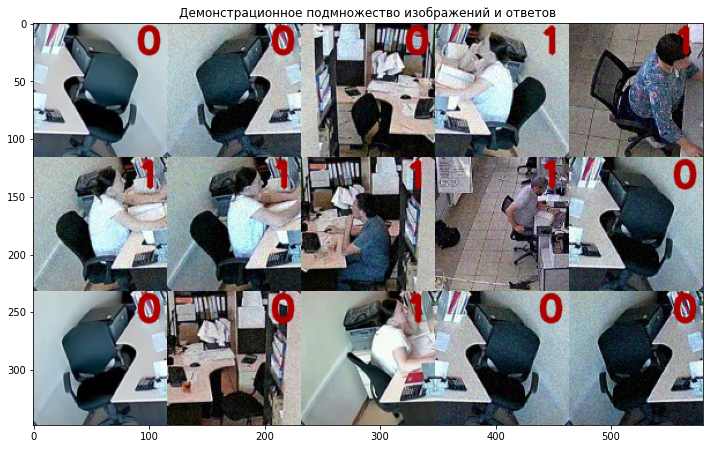

In [3]:
class DataLoader(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = np.array(y, dtype=np.float32)
        self.n = len(y)
        self.batch_size = batch_size
        self.key_array = np.arange(self.n)
        
    def __getitem__(self, index):
        indexes =  self.key_array[index * self.batch_size : (index + 1) * self.batch_size]
        X_batch = self.augumentation(indexes)
        y_batch = np.expand_dims(self.y[indexes], 1)
        return X_batch, y_batch
        
    
    def augumentation(self, indexes):
        batch = np.zeros((self.batch_size, 116, 116, 3))
        for i, j in enumerate(indexes):
            img = cv2.imread(self.X[j])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255
            img = cv2.resize(img, (116, 116))

            if np.random.binomial(1, 0.8):
                gamma = np.abs(np.random.normal(1, 0.22))
                img = pow(img , 1 / gamma)
                
            if np.random.binomial(1, 0.8):
                noise = np.random.normal(0, 0.05, size=img.shape)
                img += noise
                img = np.clip(img, 0, 1)
                
            if np.random.binomial(1, 0.5):
                img = cv2.flip(img, 1)
            
            batch[i, :, :, :] = img
            
        return batch
    
    def on_epoch_end(self):
        self.key_array = np.random.permutation(self.key_array)
    
    def __len__(self):
        return self.n // self.batch_size
    
to_plot_dataset = DataLoader(X_tr, y_tr, 15)
to_plot_dataset.on_epoch_end()
train_dataset = DataLoader(X_tr, y_tr, 8)
valid_dataset = DataLoader(X_val, y_val, 1)

def plot_figures(dataset):
    
    # get X, y
    X, y = dataset[0]
    
    # image shape and counter for reading through batch size (3 * 5 = 15 num of images inside plotting box)
    m, n, k = 3, 5, -1
    
    # template for image
    image = np.zeros((116 * m, 116 * n, 3), dtype=np.uint8)
    
    ### add label as text to image ###
    
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX
  
    # org
    org = (90, 25)

    # fontScale
    fontScale = 1

    #  color in RGB
    color = (170, 0, 0)

    # Line thickness of 2 px
    thickness = 4
    
    # Iterate through template
    for i, j in product(range(m), range(n)):
        
        # iterate through batch
        k += 1
        
        # get image from batch
        tmp_img = (X[k] * 255).astype(np.uint8)
        
        # add label as text
        tmp_img = cv2.putText(tmp_img, str(int(y[k][0])), org, font, fontScale, color, thickness, cv2.LINE_AA)
        image[116 * i : 116 * (i + 1), 116 * j : 116 * (j + 1), :] = tmp_img
        
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title('Демонстрационное подмножество изображений и ответов')
    plt.show()
        
plot_figures(to_plot_dataset)

In [4]:
# load model
model = tf.keras.models.load_model('/home/mihail/data_science/work/Fine tuning/all2.h5')
model.summary()

# freeze layers for training
for layer in model.layers[0:8]:
    layer.trainable = False

# show which layers are freezed
for layer in model.layers:
    print(layer,' <========== ', layer.trainable)

2022-06-28 19:57:25.141739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 19:57:25.148637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 19:57:25.148900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 19:57:25.149570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 116, 116, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 116, 116, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 116, 116, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 38, 8)        0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 38, 38, 8)        32        
 hNormalization)                                                 
                                                        

In [5]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.999)

In [7]:
loss_train, acc_train = [], []
loss_valid, acc_valid = [], []

In [8]:
n_batches = len(train_dataset)
n_epochs = 10
for epoch in range(n_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_acc_avg = tf.keras.metrics.Mean()
    
    for batch in tqdm(range(n_batches)):
        tf.keras.backend.clear_session()
        X_train, y_train_true = train_dataset[batch]
        
        with tf.GradientTape() as tape:
            y_train_pred = model(X_train, training=True)
            loss = ce_loss(y_true=y_train_true, y_pred=y_train_pred)
            
        grad = tape.gradient(loss, model.trainable_variables) # backpropagation
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # update weights
        
        epoch_loss_avg(loss)
        epoch_acc_avg(accuracy_score(y_true=y_train_true, y_pred=np.argmax(y_train_pred, -1)))
    
    train_dataset.on_epoch_end()
    loss_train.append(epoch_loss_avg.result())
    acc_train.append(epoch_loss_avg.result())
    
    print(f'TRAINING INFO ===========> cross entropy loss: {loss_train[-1]}, accuracy: {acc_train[-1]}')
    for i in range(len(valid_dataset)):
        X_valid_true, y_valid_true = valid_dataset[i]
        y_valid_pred = model.predict(X_valid_true) # Validation predictions
        loss_valid.append(ce_loss(y_true=y_valid_true, y_pred=y_valid_pred).numpy())
        acc_valid.append(accuracy_score(y_true=y_valid_true, y_pred=np.argmax(y_valid_pred, -1)))
    
    print(f'VALIDATION INFO ===========> cross entropy loss: {loss_valid[-1]}, accuracy: {acc_valid[-1]}')

  0%|                                                   | 0/742 [00:00<?, ?it/s]2022-06-28 19:57:30.958492: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-06-28 19:57:31.550279: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
100%|█████████████████████████████████████████| 742/742 [00:59<00:00, 12.39it/s]


TRAINING INFO ===========> cross entropy loss: 1.3713253736495972, accuracy: 1.3713253736495972
1/1 [==============================] - 0s 15ms/step
VALIDATION INFO ===========> cross entropy loss: 0.021114569157361984, accuracy: 1.0


 31%|████████████▌                            | 227/742 [00:16<00:38, 13.45it/s]


KeyboardInterrupt: 